# Exercise 3 - Niv Alterman
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

NameError: name 'torch' is not defined

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [52]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [54]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [55]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [56]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 640x480 with 0 Axes>

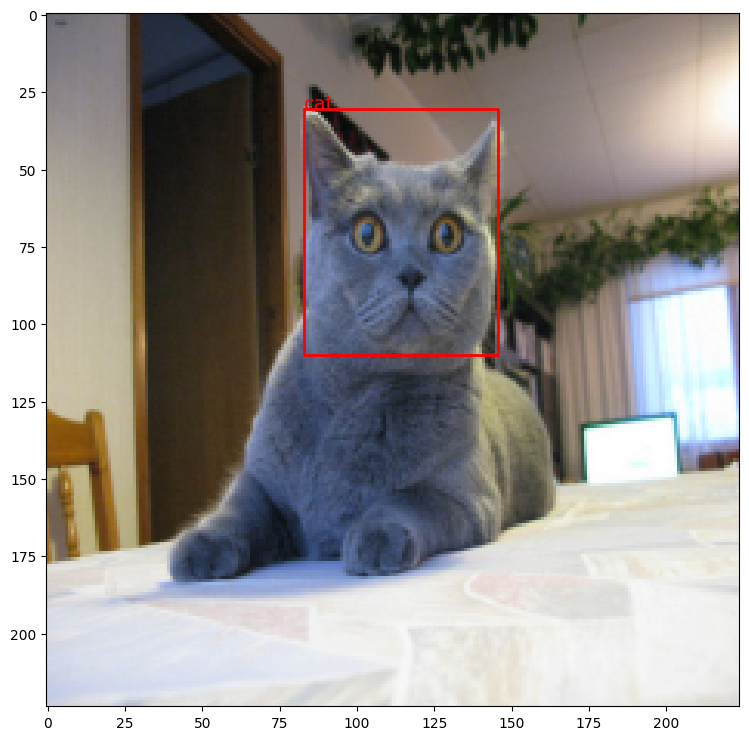

In [57]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [70]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        for param in resnet18.parameters():
            param.requires_grad = False

        # feature extracting - skip last fc layer
        self.base_resnet_layers = nn.Sequential(*list(resnet18.children())[:-1])
        # common layers of the network
        self.common_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),          
        )
        
        self.calssification_fc = nn.Sequential(
            nn.Linear(2048, num_classes)
        )
        
        self.localization_fc = nn.Sequential(
            # 4 points to (x,y,w,h)
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 4) 
        )
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        common_resnet = self.base_resnet_layers(images)
        common_fc = self.common_fc(common_resnet)
        labels_prediction = self.calssification_fc(common_fc)
        box_prediction = self.localization_fc(common_fc)
        
        return labels_prediction, box_prediction

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [71]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    total_loss_hist = []
    lables_loss_hist = []
    bbox_loss_hist = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0.0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                inputs, labels_true, boxes_true = sample['image'], sample['label'], sample['bbox']
                inputs = inputs.to(device)
                labels_true = labels_true.to(device)
                boxes_true = boxes_true.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    labels_pred, box_pred = model(inputs)
                    labels_pred_batch = torch.argmax(labels_pred, dim=1)
                    correct_predictions_batch = torch.sum(labels_pred_batch == labels_true).item()
                    
                    labels_loss_batch = criterion_cls(labels_pred, labels_true)
                    boxes_loss_batch = criterion_bbox(box_pred, boxes_true)
                    
                    batch_loss = labels_loss_batch + boxes_loss_batch
                    
                    for idx in range(len(boxes_true)):
                        boxA = boxes_true[idx]
                        boxB = box_pred[idx]
                        iou += bb_intersection_over_union(boxA, boxB)
                    
                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()
                        
                running_loss += batch_loss.item() * inputs.size(0)
                running_corrects += correct_predictions_batch
                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            total_loss_hist.append(epoch_loss)
            lables_loss_hist.append(epoch_acc)
            bbox_loss_hist.append(iou)
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    stats = {'total_loss_history': total_loss_hist, 
             'lables_loss_history':lables_loss_hist,
             'bbox_loss_history': bbox_loss_hist}
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stats

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [72]:
import torch.optim as optim

cnn = CNN(num_classes=2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [73]:
best_model, stats = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5541  |  Acc: 0.8695  |  IOU: 0.3758
val Loss: 0.2015  |  Acc: 0.9810  |  IOU: 0.5958
Epoch 2/10
----------
train Loss: 0.1832  |  Acc: 0.9764  |  IOU: 0.5628
val Loss: 0.1438  |  Acc: 0.9810  |  IOU: 0.5317
Epoch 3/10
----------
train Loss: 0.1119  |  Acc: 0.9906  |  IOU: 0.6092
val Loss: 0.1237  |  Acc: 0.9873  |  IOU: 0.5635
Epoch 4/10
----------
train Loss: 0.0983  |  Acc: 0.9874  |  IOU: 0.6431
val Loss: 0.1133  |  Acc: 0.9873  |  IOU: 0.5727
Epoch 5/10
----------
train Loss: 0.0863  |  Acc: 0.9858  |  IOU: 0.6681
val Loss: 0.1077  |  Acc: 0.9873  |  IOU: 0.5798
Epoch 6/10
----------
train Loss: 0.0793  |  Acc: 0.9874  |  IOU: 0.6842
val Loss: 0.1027  |  Acc: 0.9873  |  IOU: 0.5864
Epoch 7/10
----------
train Loss: 0.0607  |  Acc: 0.9969  |  IOU: 0.6959
val Loss: 0.0965  |  Acc: 0.9873  |  IOU: 0.5901
Epoch 8/10
----------
train Loss: 0.0506  |  Acc: 0.9953  |  IOU: 0.7142
val Loss: 0.0933  |  Acc: 0.9937  |  IOU: 0.5969
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

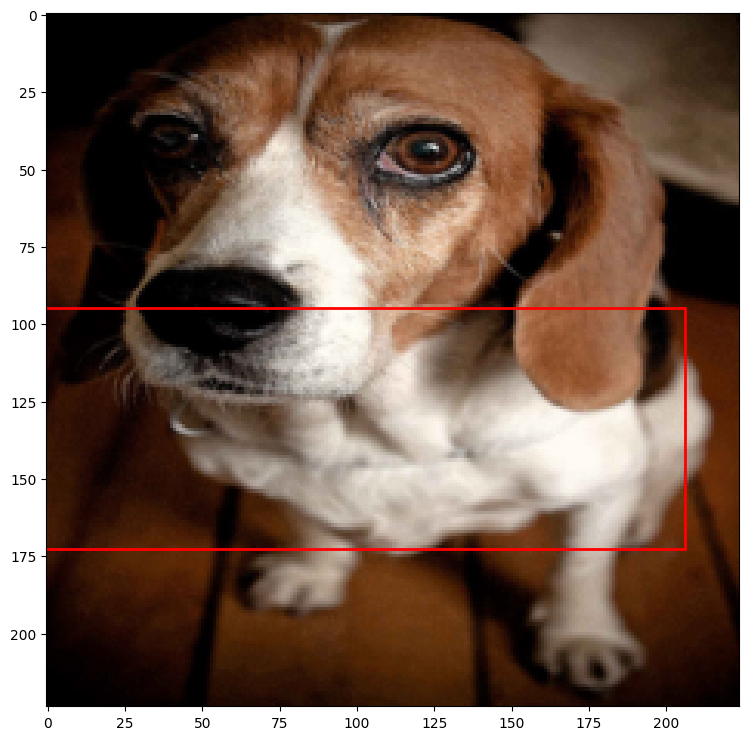

In [74]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

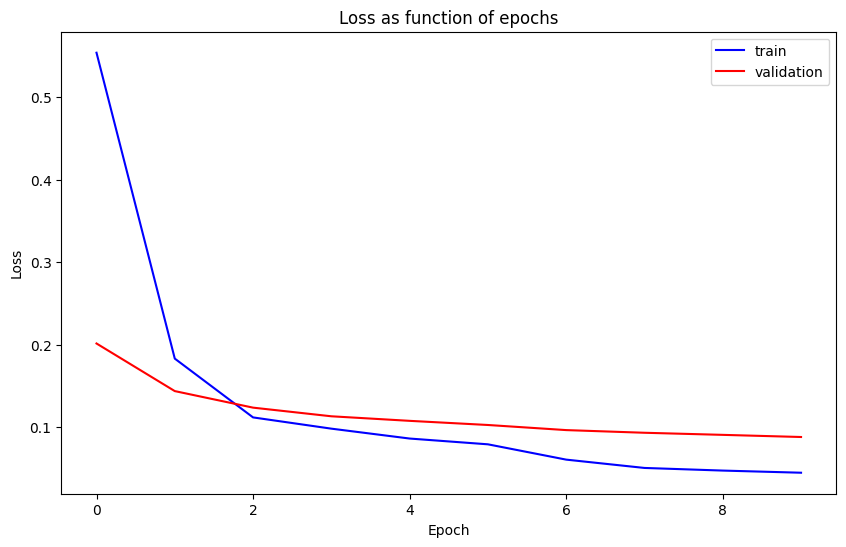

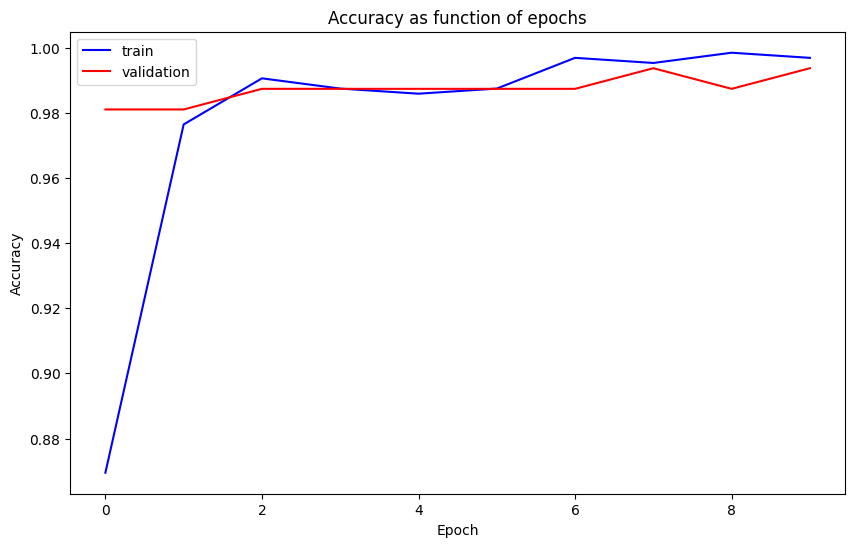

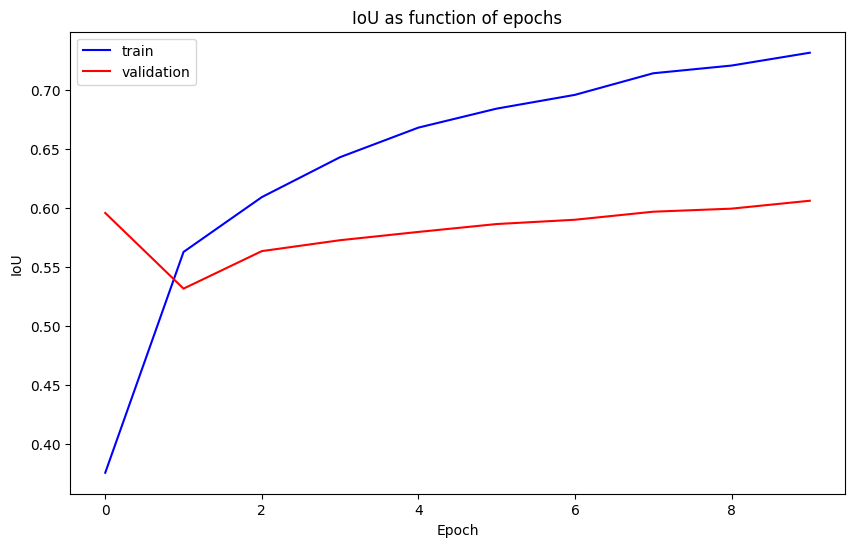

In [99]:
stats_train = {
    'Loss': [stats['total_loss_history'][i] for i in range(len(stats['total_loss_history'])) if i % 2 == 0], 
    'Accuracy': [stats['lables_loss_history'][i] for i in range(len(stats['lables_loss_history'])) if i % 2 == 0], 
    'IoU': [stats['bbox_loss_history'][i] for i in range(len(stats['bbox_loss_history'])) if i % 2 == 0] 
       }
stats_val = {
    'Loss': [stats['total_loss_history'][i] for i in range(len(stats['total_loss_history'])) if i % 2 == 1], 
    'Accuracy': [stats['lables_loss_history'][i] for i in range(len(stats['lables_loss_history'])) if i % 2 == 1], 
    'IoU': [stats['bbox_loss_history'][i] for i in range(len(stats['bbox_loss_history'])) if i % 2 == 1] 
       }

# show visualization of the model's predictions on the validation set in matplotlib
for key in stats_train.keys():
    plt.subplots(1,1,figsize=(10,6))
    plt.plot(range(len(stats_train[key])), stats_train[key], label="train", color="blue")
    plt.plot(range(len(stats_val[key])), stats_val[key], label="validation", color="red")
    plt.xlabel("Epoch")
    plt.ylabel(f"{key}")
    plt.title(f"{key} as function of epochs")
    plt.legend()
